## Springboard MLE Capstone
### Used Car Price Predictor - Deep Learning approach
##### Author - Joyjit Chowdhury, Springboard - MLE

## 1:  Objective
This is a Deep Learning (DL) approach for my Capstone Project - Used Car Price Prediction.
Details mentioned below:

- **ML Problem Class** :  _Regression_
- **Inputs**   :  _Used car attributes - **year,make,model,trim,odometer,state,colorexterior,accidenthist,owner,usage**_ <br/>
    **Example**:

            "year" : 2014,
            "make" : "toyota",
            "model" : "corolla",
            "trim" : "le plus",
            "odometer" : 20700,
            "state" :  "AZ",
            "colorexterior" : "blue",
            "colorinterior" : "black",
            "accidenthist" : "n",
            "owner" : 5,
            "usage" : "personal"
            
            
- **Output**  :  Price of the used car

## 2:  High Level Design

- **Implementation**   :  _Sequential model with Keras (Tensorflow Backend)_

- **Model architecture**       :  _Artificial Neural Network with 4 layers_ 
  - 1 input layer   10 units  
  - 1 hidden layer  20 units    
  - 1 hidden layer   5 units     
  - 1 output layer   1 unit       
    
- **Activation functions** :  _ReLu_

- **Initializer** : _Xavier (glorot uniform)_

- **Cost Optmizer** : SGD (Stochastic Gradient Descent)

- **Loss Function** : MSE (Mean Squared Error)
- **Epochs and Callback** : 1000 epochs with Early Stopping Callback for 5 iterations
- **Input Feature Augmentation**: 
  - Mandatory_input_features = year, make, model,trim, odometer,state,colorexterior,colorinterior
  - Features augmented - ReliabilityRank,CostOfLivingRank,PercentSales, AvgDaysToTurn,ReviewScore,AvgMPG, LuxurySportsOrHybrid, drivetrain,bodytype
- **Feature Encoding**: 
  - Numeric features - ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,age,odo
  - Categorical features to be OneHot encoded - owner,usage,LuxurySportsOrHybrid,drivetrain,accidenthist,colorexterior, colorinterior, bodytype

# 3: Model development

In [21]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
from fuzzywuzzy import fuzz
import pickle
import tensorflow as tf
from datetime import datetime

pd.set_option('display.max_colwidth',0)
pd.set_option('display.float_format',lambda x: '%.2f' %x)
pd.set_option('display.max_columns',0)


### 3.1 Feature Transformation

In [2]:
# Features 

numeric_features = ['ReliabilityRank', 'CostOfLivingRank', 'PercentSales', 'AvgDaysToTurn',
                    'ReviewScore', 'AvgMPG', 'age', 'odo','price']

cat_features = {
            'owner' : ['0', '1','2'],
            'usage' : ['FLEET','PERSONAL'],
            'LuxurySportsOrHybrid' : ['N','U','Y'],
            'drivetrain' : ['AWD', 'FWD'],
            'accidenthist' : ['N','Y'],
            'colorexterior' : ['BLACK', 'BLUE','GRAY','OTHER',  'RED',  'SILVER','WHITE'],
            'colorinterior' : ['BEIGE','BLACK', 'GRAY', 'OTHER'],
            'bodytype' :['CONVERTIBLE','COUPE', 'HATCHBACK', 'PICKUP','SEDAN', 'SUV', 'TRUCK','VAN/MINIVAN', 'WAGON']
            }

onehot_features = []
for x in cat_features.keys():
    onehot_features.extend([(x + '_' + v) for v in cat_features[x]])

final_column_set = numeric_features + onehot_features
    
mandatory_input_features = ['year', 'make', 'model', 'trim', 'odometer', 'state', 'colorexterior','colorinterior']

In [3]:
# Transformer classes

class CarDataStandardizer():
    
    def __init__(self):        
        print("Initialized standardizer")  
        
    def fit(self):
        return self
    
    def transform(self, df):
        # merge the data
        df_input = df.copy()
        
        for col in ['make','model','trim','state','colorexterior','colorinterior','accidenthist','usage']:
            df_input[col] = df_input[col].astype(str).apply(lambda x:x.upper().strip())           

        df_input['colorexterior'] = df_input['colorexterior'].apply(lambda x: x if x in ['WHITE', 'BLACK', 'SILVER', 'GRAY', 'BLUE', 'RED'] else 'OTHER')
        df_input['colorinterior'] = df_input['colorinterior'].apply(lambda x: x if x in ['BLACK', 'GRAY', 'BEIGE'] else 'OTHER')       
            
        df_input['age'] = datetime.now().year - df_input['year'].astype('int')
        df_input['odo'] = df_input['odometer'].astype('int') / 1000
        df_input['price'] = df_input['price'].astype('int') / 1000
        df_input = df_input.drop(columns = ['odometer'])
        
        df_input['owner'] = pd.cut(x=df_input['owner'], bins=[-1,0,1,20], labels=[0,1,2])
        
        return df_input
    

In [4]:
class CarDataAugmentor():
    
    def __init__(self):
        
        # prepare augment data from files
        print("Initialized CarDataAugmentor") 
        
        self.df_category = pd.read_csv('car_category.csv', index_col = False)

        self.df_reliability = pd.read_csv('car_reliability_rankings.csv', index_col = False)
        self.df_reliability = self.df_reliability[['Make','ReliabilityRank']]

        self.df_cost = pd.read_csv('statewise_economic_indicators.csv',index_col = False)
        self.df_cost = self.df_cost[['State','CostOfLivingRank']]

        self.df_sales = pd.read_csv('car_sales.csv',index_col = False)
        self.df_sales = self.df_sales.drop(columns = ['TotalSales'])

        self.df_turn = pd.read_csv("used_car_time_to_turn.csv")
        self.df_turn['AvgDaysToTurn'] = self.df_turn.mean(axis=1)
        self.df_turn['Make'] = self.df_turn['Make'].str.upper()
        self.df_turn = self.df_turn[['Make','AvgDaysToTurn']]


        self.df_ratings = pd.read_csv('car_ratings.csv', index_col = False)
        self.df_ratings.drop_duplicates(subset = ['MakeModel'], inplace = True)
        self.df_ratings['AvgMPG'] = (self.df_ratings['MpgCity']  + self.df_ratings['MpgHwy']) / 2
        self.df_ratings.loc[self.df_ratings['CarClass'].str.contains(r'LUXURY|SPORTS|HYBRID'),'LuxurySportsOrHybrid'] = 'Y'
        self.df_ratings['LuxurySportsOrHybrid']  = self.df_ratings['LuxurySportsOrHybrid'].fillna('N')
        self.df_ratings = self.df_ratings[['MakeModel','ReviewScore','AvgMPG','LuxurySportsOrHybrid']]
 
    def fit(self):
        return self

    def transform(self, df):
        # merge the data
        df_input = df.copy()
        
        df_input = df_input.merge(self.df_reliability,how = 'left',left_on='make', right_on='Make')
        df_input = df_input.drop(columns = ['Make'])
        
        df_input = df_input.merge(self.df_cost,how = 'left',left_on=['state'], right_on=['State'])
        df_input = df_input.drop(columns = ['State'])
 
        df_input = df_input.merge(self.df_sales,how = 'left',left_on=['make'], right_on=['Make'])
        df_input = df_input.drop(columns = ['Make'])
        
        df_input = df_input.merge(self.df_turn,how = 'left',left_on=['make'], right_on=['Make'])
        df_input = df_input.drop(columns = ['Make'])
        
        df_input = df_input.merge(self.df_category,how = 'left', 
                                  left_on = ['year','make','model'], 
                                  right_on = ['Year','Make','Model'])
        df_input = df_input.drop(columns = ['Year','Make','Model']).rename({'Category' : 'bodytype'},axis = 1)


        # Function to do fuzzy matching of make and model combination to get ratings
        def getclass(makemodel):

            try:
                matches = self.df_ratings['MakeModel'].apply(lambda x:fuzz.ratio(x,makemodel))
                if matches.max() > 80:
                    return matches.idxmax()
                else:
                    return -1
            except:
                return -1


        df_input['makemodel'] = df_input['make'] + ' ' + df_input['model'] 
        df_input['matchindex'] = df_input['makemodel'].apply(getclass)
        df_input = df_input.merge(self.df_ratings, how = 'left', left_on = 'matchindex', right_index = True)
        df_input = df_input.drop(columns = ['makemodel','matchindex','MakeModel'])

        def getdrivetrain(trim):

            try:
                drivetrain = [d for d in ['AWD','RWD','FWD','4WD','2WD'] if d in trim]
                drivetrain = drivetrain[0] if len(drivetrain) > 0 else 'FWD'
                drivetrain = 'FWD' if drivetrain in ['FWD','2WD'] else 'AWD'
                return drivetrain
            except:
                return 'FWD'

        df_input['drivetrain'] = df_input['trim'].apply(getdrivetrain)
        
        df_final = df_input.drop(columns = ['year', 'make', 'model', 'trim', 'state'])
        
        df_final = df_final.dropna()

        return df_final
    

In [5]:
class OneHotTransformer():
    
    def __init__(self):
        
        print("Initialized OneHotTransformer") 
        self.attlist = list(cat_features.keys())        
        self.att_columns = onehot_features
        
        
    def fit(self, df):
        return self

    def transform(self, df):
        
        df_input = df.copy()
        
        att_dummies = pd.get_dummies(df_input[self.attlist])
        att_dummies = att_dummies.reindex(columns = self.att_columns, fill_value=0)        
        df_final = pd.concat([df_input, att_dummies], axis=1)
        df_final.drop(columns = self.attlist, axis=1, inplace=True)        
        
    
        return df_final
    
   

In [6]:
 
class PreModelValidator():
    
    def __init__(self):
        
        print("Initialized PreModelValidator")         
        
    def fit(self, df):
        return self

    def transform(self, df):
        
        df_input = df.copy()
        
        assert set(df_input.columns) == set(final_column_set)      
        
        # Ensure no nulls
        assert df_input.isnull().values.any() == False, "Null Values exist in features"
        
       
        # Ensure No Non-Numeric
        assert is_numeric_dtype(df_input.values) == True, "Non-numeric Values exist in features"
    
    
        df_final = df_input[final_column_set]
    
        return df_final

In [7]:
# Transformer Pipeline

from sklearn.pipeline import Pipeline
transformer_pipeline = Pipeline(steps=[('standardize', CarDataStandardizer()), 
                                         ('augment',CarDataAugmentor()),
                                         ('onehot', OneHotTransformer()),
                                         ('validate',PreModelValidator())
                                         ])

Initialized standardizer
Initialized CarDataAugmentor
Initialized OneHotTransformer
Initialized PreModelValidator


In [8]:
# Test Transform data

in_data = [{
            "year" : 2014,
            "make" : "toyota",
            "model" : "corolla",
            "trim" : "le plus",
            "odometer" : 20700,
            "state" :  "AZ",
            "colorexterior" : "blue",
            "colorinterior" : "black",
            "accidenthist" : "n",
            "owner" : 5,
            "usage" : "personal",
            "price" : 0
            }]


df_in = pd.DataFrame.from_dict(in_data)
df_out = transformer_pipeline.transform(df_in)
df_out

,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,age,odo,price,owner_0,owner_1,owner_2,usage_FLEET,usage_PERSONAL,LuxurySportsOrHybrid_N,LuxurySportsOrHybrid_U,LuxurySportsOrHybrid_Y,drivetrain_AWD,drivetrain_FWD,accidenthist_N,accidenthist_Y,colorexterior_BLACK,colorexterior_BLUE,colorexterior_GRAY,colorexterior_OTHER,colorexterior_RED,colorexterior_SILVER,colorexterior_WHITE,colorinterior_BEIGE,colorinterior_BLACK,colorinterior_GRAY,colorinterior_OTHER,bodytype_CONVERTIBLE,bodytype_COUPE,bodytype_HATCHBACK,bodytype_PICKUP,bodytype_SEDAN,bodytype_SUV,bodytype_TRUCK,bodytype_VAN/MINIVAN,bodytype_WAGON
0,5,29,12.19,43.23,7.90,32.00,6,20.70,0.00,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [9]:
# Get training / testing dataset from csv file

df_raw_input = pd.read_csv('cardata_for_DL.csv',encoding = "ISO-8859-1",index_col=False)
df_raw_input.sample(10,random_state = 1)

,year,make,model,trim,odometer,state,colorexterior,colorinterior,accidenthist,owner,usage,price
8674,2017,TOYOTA,COROLLA,SE CVT,100704,FL,BLUE,UNKNOWN,N,1,PERSONAL,10982
45,2019,NISSAN,ROGUE,SV FWD,26642,CA,SILVER,BLACK,N,1,PERSONAL,15097
685,2016,NISSAN,VERSA,1.6 SV CVT,84466,CA,SILVER,BLACK,N,2,PERSONAL,6804
7095,2019,NISSAN,SENTRA,SV CVT,8251,FL,SILVER,BLACK,N,1,PERSONAL,14390
1227,2019,FORD,FIESTA,SE HATCHBACK,30856,CA,GRAY,BLACK,Y,1,PERSONAL,11398
5926,2017,TOYOTA,HIGHLANDER,LE PLUS V6 FWD,51064,TX,WHITE,UNKNOWN,N,1,PERSONAL,23000
4207,2015,CHEVROLET,SILVERADO 1500,WT REGULAR CAB LONG BOX 2WD,109166,NC,WHITE,GRAY,N,3,PERSONAL,11988
8279,2019,CHEVROLET,SUBURBAN,LT 4WD,22963,TX,SILVER,BLACK,N,1,PERSONAL,43995
5673,2018,FIAT,500,LOUNGE HATCHBACK,5054,WA,WHITE,BLACK,N,1,PERSONAL,11988
6970,1997,MERCEDES-BENZ,ECLASS,E 320,65504,NC,BLUE,GRAY,N,3,PERSONAL,4995


In [10]:
# Transform input data

df_transformed_input = transformer_pipeline.transform(df_raw_input)
df_transformed_input.to_csv("car_data_pre_model.csv",index = False)
df_transformed_input.sample(10,random_state = 1)


,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,age,odo,price,owner_0,owner_1,owner_2,usage_FLEET,usage_PERSONAL,LuxurySportsOrHybrid_N,LuxurySportsOrHybrid_U,LuxurySportsOrHybrid_Y,drivetrain_AWD,drivetrain_FWD,accidenthist_N,accidenthist_Y,colorexterior_BLACK,colorexterior_BLUE,colorexterior_GRAY,colorexterior_OTHER,colorexterior_RED,colorexterior_SILVER,colorexterior_WHITE,colorinterior_BEIGE,colorinterior_BLACK,colorinterior_GRAY,colorinterior_OTHER,bodytype_CONVERTIBLE,bodytype_COUPE,bodytype_HATCHBACK,bodytype_PICKUP,bodytype_SEDAN,bodytype_SUV,bodytype_TRUCK,bodytype_VAN/MINIVAN,bodytype_WAGON
7023,6.00,15,2.22,58.77,7.80,30.50,6,41.25,12.85,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0
2926,16.00,10,6.29,76.23,6.90,35.00,1,40.62,9.99,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
6121,10.00,14,13.83,71.62,8.20,26.00,1,42.78,16.00,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3664,16.00,29,6.29,76.23,7.20,33.00,3,32.82,9.50,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
7972,18.00,7,8.34,48.69,8.10,34.00,3,36.46,15.48,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4140,10.00,14,13.83,71.62,8.20,26.00,1,20.90,16.99,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
7678,23.00,14,4.13,23.23,8.20,28.50,10,152.28,5.66,0,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5248,10.00,50,13.83,71.62,8.20,26.00,1,6.96,17.50,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3549,14.00,2,3.99,73.38,8.50,28.50,1,48.83,14.49,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1938,18.00,6,8.34,48.69,8.10,34.00,3,35.45,15.88,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [13]:
df_X = df_transformed_input[df_transformed_input.columns[~df_transformed_input.columns.isin(['price'])]]
df_y = df_transformed_input['price']

In [15]:
df_X

,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,age,odo,owner_0,owner_1,owner_2,usage_FLEET,usage_PERSONAL,LuxurySportsOrHybrid_N,LuxurySportsOrHybrid_U,LuxurySportsOrHybrid_Y,drivetrain_AWD,drivetrain_FWD,accidenthist_N,accidenthist_Y,colorexterior_BLACK,colorexterior_BLUE,colorexterior_GRAY,colorexterior_OTHER,colorexterior_RED,colorexterior_SILVER,colorexterior_WHITE,colorinterior_BEIGE,colorinterior_BLACK,colorinterior_GRAY,colorinterior_OTHER,bodytype_CONVERTIBLE,bodytype_COUPE,bodytype_HATCHBACK,bodytype_PICKUP,bodytype_SEDAN,bodytype_SUV,bodytype_TRUCK,bodytype_VAN/MINIVAN,bodytype_WAGON
0,8.00,39,1.78,74.00,7.50,113.00,5,21.49,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,9.00,49,11.69,78.23,8.40,29.00,2,37.07,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,23.00,14,4.13,23.23,7.70,33.00,1,15.91,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,5.00,14,12.19,43.23,7.90,32.00,0,18.73,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
5,18.00,43,8.34,48.69,8.20,34.00,3,186.24,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,15.00,47,1.20,55.38,8.30,25.50,5,83.08,0,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
9330,5.00,7,12.19,43.23,7.90,30.50,3,34.49,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
9332,16.00,14,6.29,76.23,7.20,33.00,1,2.82,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
9333,5.00,22,12.19,43.23,7.90,30.50,2,43.91,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [16]:
# Get input values (independent variables)
X = df_X.values
# Get target column values (dependent variable to be predicted)
y = df_y.values


print(f"Final Shapes of X : {X.shape} and y : {y.shape}")

Final Shapes of X : (7485, 40) and y : (7485,)


### 3.2 Train Test Split

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state=0)
print('x_train = {} y_train = {} x_test = {} y_test = {}'.format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

x_train = (5613, 40) y_train = (5613,) x_test = (1872, 40) y_test = (1872,)


### 3.3 Model creation


In [23]:
from tensorflow.keras.models import Sequential,Model,model_from_json
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import glorot_uniform

tf.logging.set_verbosity(tf.logging.ERROR)


In [47]:
def baseline_model():
    # build model
    model = Sequential()
    model.add(Dense(40, input_dim=40, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20,kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='glorot_uniform'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [48]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 40)                1640      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________


### 3.4 Model training

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 50)

history = model.fit(
                    X_train, 
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [early_stopping]
)

Train on 5613 samples, validate on 1872 samples
Epoch 1/1000
5613/5613 [==============================] - 1s 120us/step - loss: 156.4370 - val_loss: 66.1486
Epoch 2/1000
5613/5613 [==============================] - 0s 38us/step - loss: 77.6737 - val_loss: 51.4241
Epoch 3/1000
5613/5613 [==============================] - 0s 39us/step - loss: 67.7194 - val_loss: 45.0077
Epoch 4/1000
5613/5613 [==============================] - 0s 40us/step - loss: 57.8727 - val_loss: 35.5799
Epoch 5/1000
5613/5613 [==============================] - 0s 39us/step - loss: 51.0104 - val_loss: 30.2139
Epoch 6/1000
5613/5613 [==============================] - 0s 39us/step - loss: 44.5898 - val_loss: 27.1093
Epoch 7/1000
5613/5613 [==============================] - 0s 40us/step - loss: 41.0246 - val_loss: 24.5923
Epoch 8/1000
5613/5613 [==============================] - 0s 40us/step - loss: 37.2703 - val_loss: 21.3255
Epoch 9/1000
5613/5613 [==============================] - 0s 40us/step - loss: 35.1578 - val_l

Epoch 77/1000
5613/5613 [==============================] - 0s 39us/step - loss: 16.0617 - val_loss: 8.8954
Epoch 78/1000
5613/5613 [==============================] - 0s 39us/step - loss: 15.9802 - val_loss: 8.4380
Epoch 79/1000
5613/5613 [==============================] - 0s 40us/step - loss: 15.2434 - val_loss: 9.1211
Epoch 80/1000
5613/5613 [==============================] - 0s 39us/step - loss: 16.5042 - val_loss: 9.4821
Epoch 81/1000
5613/5613 [==============================] - 0s 38us/step - loss: 15.3700 - val_loss: 8.2247
Epoch 82/1000
5613/5613 [==============================] - 0s 42us/step - loss: 15.4296 - val_loss: 8.1144
Epoch 83/1000
5613/5613 [==============================] - 0s 38us/step - loss: 15.5185 - val_loss: 9.3695
Epoch 84/1000
5613/5613 [==============================] - 0s 41us/step - loss: 15.2244 - val_loss: 8.1846
Epoch 85/1000
5613/5613 [==============================] - 0s 40us/step - loss: 14.7075 - val_loss: 8.4416
Epoch 86/1000
5613/5613 [============

5613/5613 [==============================] - 0s 43us/step - loss: 12.8815 - val_loss: 8.0988
Epoch 154/1000
5613/5613 [==============================] - 0s 39us/step - loss: 12.4395 - val_loss: 8.3305
Epoch 155/1000
5613/5613 [==============================] - 0s 43us/step - loss: 12.5513 - val_loss: 8.0475
Epoch 156/1000
5613/5613 [==============================] - 0s 42us/step - loss: 12.2393 - val_loss: 7.8444
Epoch 157/1000
5613/5613 [==============================] - 0s 45us/step - loss: 12.4485 - val_loss: 8.4518
Epoch 158/1000
5613/5613 [==============================] - 0s 46us/step - loss: 12.8241 - val_loss: 7.8508
Epoch 159/1000
5613/5613 [==============================] - 0s 41us/step - loss: 12.5120 - val_loss: 7.8362
Epoch 160/1000
5613/5613 [==============================] - 0s 40us/step - loss: 13.0783 - val_loss: 8.3892
Epoch 161/1000
5613/5613 [==============================] - 0s 41us/step - loss: 13.0238 - val_loss: 7.9727
Epoch 162/1000
5613/5613 [=================

### 3.5: Get Predictions

In [50]:
preds = model.predict(X_test)
preds

array([[33.75187  ],
       [24.66762  ],
       [10.856634 ],
       ...,
       [10.657028 ],
       [10.7155485],
       [19.35977  ]], dtype=float32)

### 3.6: Plot Predictions vs Actuals

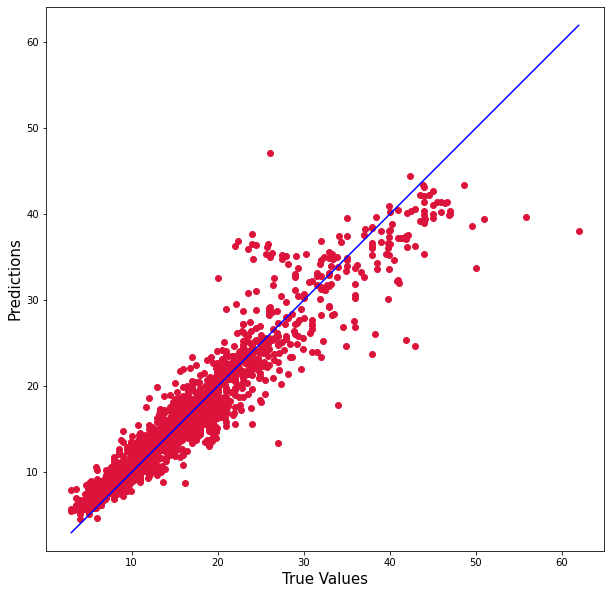

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, preds, c='crimson')

p1 = max(max(preds), max(y_test))
p2 = min(min(preds), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 3.7: Loss function plot

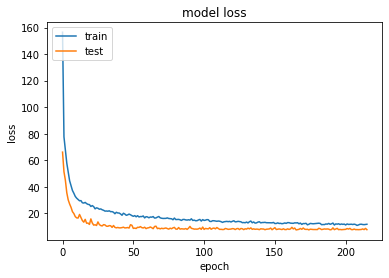

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Observations

We see a good prediction trend above as evident from the scatter plot and the loss function curve.
There are a few outliers in predictions where prices are under-predicted.

## Save the model to h5

In [53]:
# Save model 
model.save("Used_Car_Price_NN.h5")